# Imports

In [41]:
import numpy as np
import pandas as pd
import os

from math import pi

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score as ars
from sklearn.preprocessing import StandardScaler

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine, text

engine = create_engine('sqlite://', echo = False)

## Import csv and SQL table

In [42]:
customers = pd.read_csv('clean/customers.csv')
order_items = pd.read_csv('clean/order_items.csv')
order_reviews = pd.read_csv('clean/order_reviews.csv')
orders = pd.read_csv('clean/orders.csv')


customers.to_sql('customers', con=engine)
order_items.to_sql('order_items', con=engine)
order_reviews.to_sql('order_reviews', con=engine)
orders.to_sql('orders', con=engine)

99441

In [43]:
query0 = text('''
DROP TABLE IF EXISTS RFM_Extended
''')

query1 = text('''
CREATE TABLE IF NOT EXISTS RFM_Extended AS
        SELECT
            customer_unique_id,
            AVG(oi.price) AS Monetary,
            COUNT(o.order_id) AS Frequency,
            JULIANDAY((SELECT MAX(order_purchase_timestamp) FROM orders)) - JULIANDAY(MAX(o.order_purchase_timestamp)) AS Recency,
            AVG(COALESCE(orv.review_score, 0)) AS AVG_review,
            AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)) AS AVG_delivery_time,
            MAX(o.order_purchase_timestamp) AS Last_Order_Date
        FROM
        orders o
        LEFT JOIN
        order_items oi ON o.order_id = oi.order_id
        LEFT JOIN
        customers c ON o.customer_id = c.customer_id
        LEFT JOIN order_reviews orv ON o.order_id = orv.order_id
        GROUP BY c.customer_unique_id;
''')



query2 = '''
SELECT * FROM RFM_Extended
'''
with engine.connect() as connection:
    connection.execute(query0)
    connection.execute(query1)
pd.read_sql_query(query2, con=engine)

,customer_unique_id,Monetary,Frequency,Recency,AVG_review,AVG_delivery_time,Last_Order_Date
0,None,102.449567,4402,0.884907,4.014312,12.086368,2018-10-16 20:16:02
1,0000366f3b9a7992bf8c76cfdf3221e2,129.900000,1,160.273507,5.000000,6.411227,2018-05-10 10:56:27
2,0000b849f77a49e4a4ce2b2a4ca5be3f,18.900000,1,163.263090,4.000000,3.285590,2018-05-07 11:11:27
3,0000f46a3911fa3c0805444483337064,69.000000,1,585.850868,3.000000,25.731759,2017-03-10 21:05:03
4,0000f6ccb0745a6a4b88665a16c9f078,25.990000,1,369.875428,4.000000,20.037083,2017-10-12 20:29:41
...,...,...,...,...,...,...,...
96092,fffcf5a5ff07b0908bd4e2dbc735a684,785.000000,2,495.853958,5.000000,27.514861,2017-06-08 21:00:36
96093,fffea47cd6d3cc0a88bd621562a9d061,64.890000,1,310.890532,4.000000,30.097500,2017-12-10 20:07:56
96094,ffff371b4d645b6ecea244b27531430a,89.900000,1,617.070162,5.000000,14.872083,2017-02-07 15:49:16
96095,ffff5962728ec6157033ef9805bacc48,115.000000,1,168.092095,5.000000,11.858854,2018-05-02 15:17:41


In [44]:
df_rfm_extended = pd.read_sql('SELECT * FROM RFM_Extended', engine)

##  Cleaning

In [45]:
def cleandf(df):
    monetary_median = df['Monetary'].median()
    df.loc[:, 'Monetary'] = df['Monetary'].fillna(monetary_median)
    df.loc[:, 'AVG_delivery_time'] = df['AVG_delivery_time'].fillna(-1)
    df = df[df['customer_unique_id'].notnull()]
    df = df[df['customer_unique_id'] != 'None']
    df = df[df['customer_unique_id'] != 0]
    return df


In [46]:
df_rfm_extended = cleandf(df_rfm_extended)

In [47]:
df_rfm_extended

,customer_unique_id,Monetary,Frequency,Recency,AVG_review,AVG_delivery_time,Last_Order_Date
1,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,160.273507,5.0,6.411227,2018-05-10 10:56:27
2,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,163.263090,4.0,3.285590,2018-05-07 11:11:27
3,0000f46a3911fa3c0805444483337064,69.00,1,585.850868,3.0,25.731759,2017-03-10 21:05:03
4,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,369.875428,4.0,20.037083,2017-10-12 20:29:41
5,0004aac84e0df4da2b147fca70cf8255,180.00,1,336.905972,5.0,13.141134,2017-11-14 19:45:42
...,...,...,...,...,...,...,...
96092,fffcf5a5ff07b0908bd4e2dbc735a684,785.00,2,495.853958,5.0,27.514861,2017-06-08 21:00:36
96093,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,310.890532,4.0,30.097500,2017-12-10 20:07:56
96094,ffff371b4d645b6ecea244b27531430a,89.90,1,617.070162,5.0,14.872083,2017-02-07 15:49:16
96095,ffff5962728ec6157033ef9805bacc48,115.00,1,168.092095,5.0,11.858854,2018-05-02 15:17:41


In [48]:
scaler = StandardScaler()

variables = ['Monetary', 'Frequency', 'Recency']

df_rfm_scaled = scaler.fit_transform(df_rfm_extended[variables])
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=variables)

# RFM

## RFM KMeans

In [49]:
def kmeans_plot(df):
  sse = {}
  for k in range(1, 11):
      kmeans = KMeans(n_clusters=k, random_state=1)
      kmeans.fit(df)
      sse[k] = kmeans.inertia_

  plt.figure()
  plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
  plt.xlabel('Nombre de clusters')
  plt.ylabel('SSE')
  plt.title('La méthode du Coude pour déterminer le nombre optimal de clusters')
  plt.show()

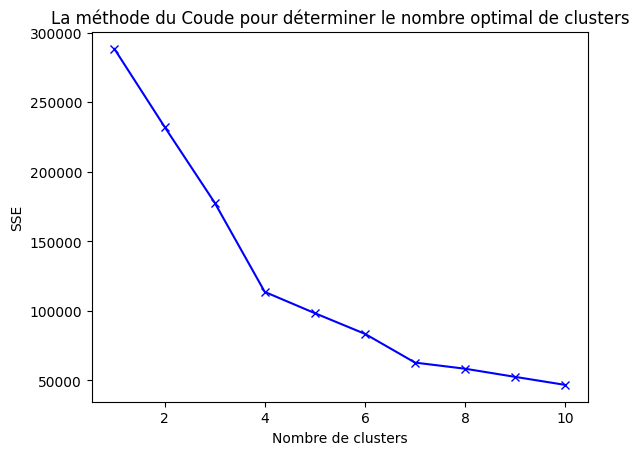

In [50]:
kmeans_plot(df_rfm_scaled)

### Manually define the number of clusters

In [51]:
rfm_kmean_cluster = 4

In [52]:
def store_nb_cluster(nb_cluster, df):
  kmeans = KMeans(n_clusters=nb_cluster, random_state=42)
  df['Cluster'] = kmeans.fit_predict(df)

  cluster_summary = df.groupby('Cluster').mean()
  print(cluster_summary)
  return cluster_summary

In [53]:
cluster_summary = store_nb_cluster(rfm_kmean_cluster,df_rfm_scaled)

         Monetary  Frequency   Recency
Cluster                               
0        0.223777  -0.260470 -0.993659
1       -0.221285  -0.262581  0.047149
2       -0.236298   2.439419 -0.150164
3        0.111115  -0.196445  1.419321


## RFM Clusters Boxplot

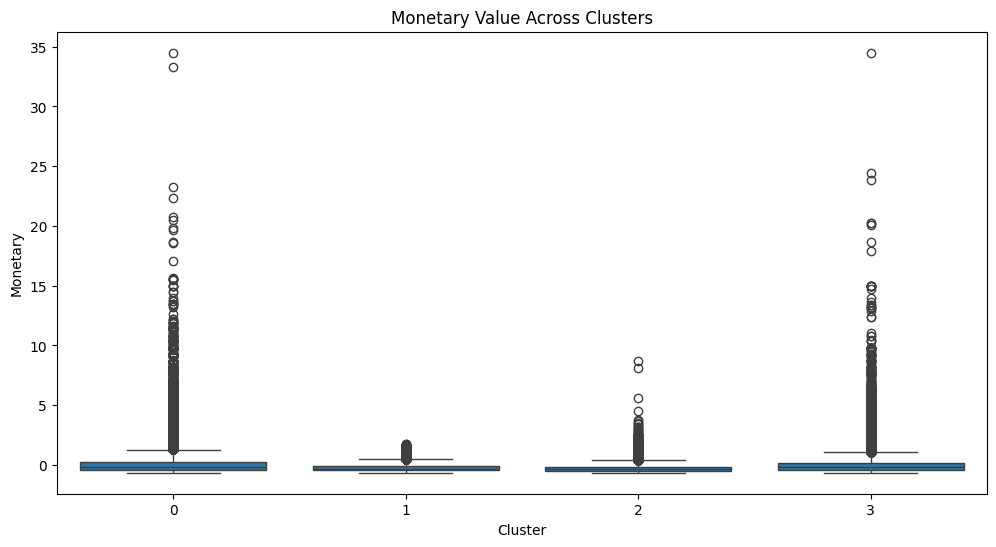

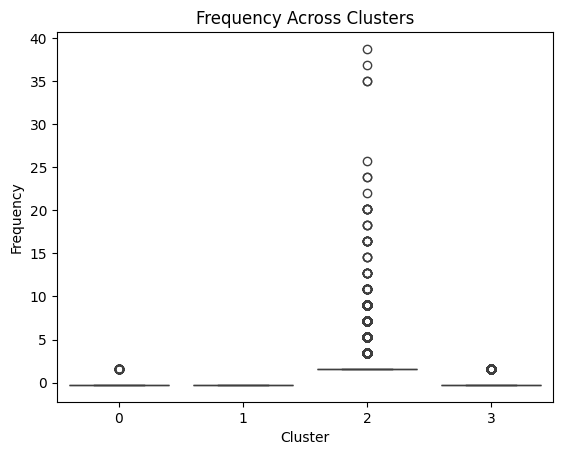

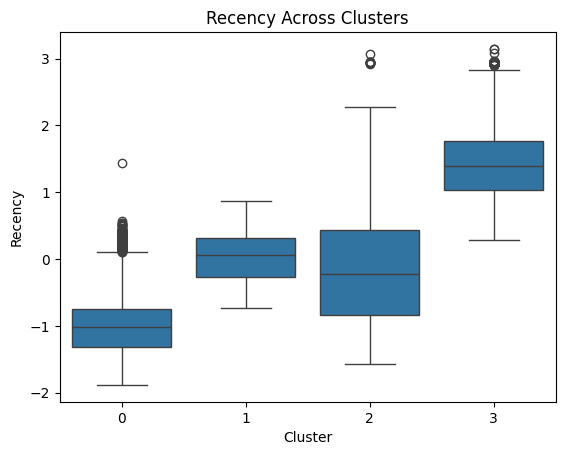

In [54]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Monetary', data=df_rfm_scaled)
plt.title('Monetary Value Across Clusters')
plt.show()

sns.boxplot(x='Cluster', y='Frequency', data=df_rfm_scaled)
plt.title('Frequency Across Clusters')
plt.show()

sns.boxplot(x='Cluster', y='Recency', data=df_rfm_scaled)
plt.title('Recency Across Clusters')
plt.show()

## RFM Clusters Radar Chart

In [55]:

def radar_char(cluster_summary, variables) :
    cluster_means = cluster_summary[variables].values
    num_vars = cluster_means.shape[1]

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for i, cluster in enumerate(cluster_means):
        values = cluster.tolist()
        values += values[:1]
        ax.fill(angles, values, alpha=0.25, label=f'Cluster {i}')
        ax.plot(angles, values)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(variables)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Radar Chart for Cluster Characteristics')
    plt.show()

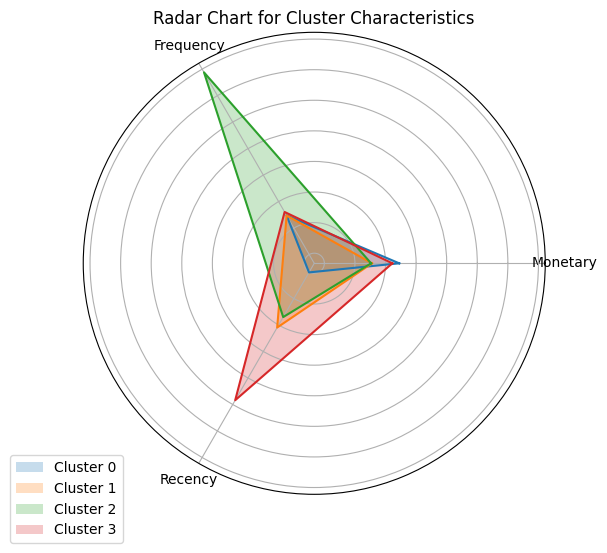

In [56]:
radar_char(cluster_summary, variables)

## RFM Clusters Repartition

In [57]:

def cluster_plots(df, variables):
  fig, axs = plt.subplots(len(variables), len(variables), figsize=(12, 12))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i, var1 in enumerate(variables):
      for j, var2 in enumerate(variables):
          if i != j:
              axs[i, j].scatter(df[var1], df[var2],
                                c=df['Cluster'], cmap='viridis', alpha=0.6)
              axs[i, j].set_xlabel(var1)
              axs[i, j].set_ylabel(var2)
          else:
              axs[i, j].hist(df[var1], bins=20, color='gray')
              axs[i, j].set_xlabel(var1)

  plt.show()

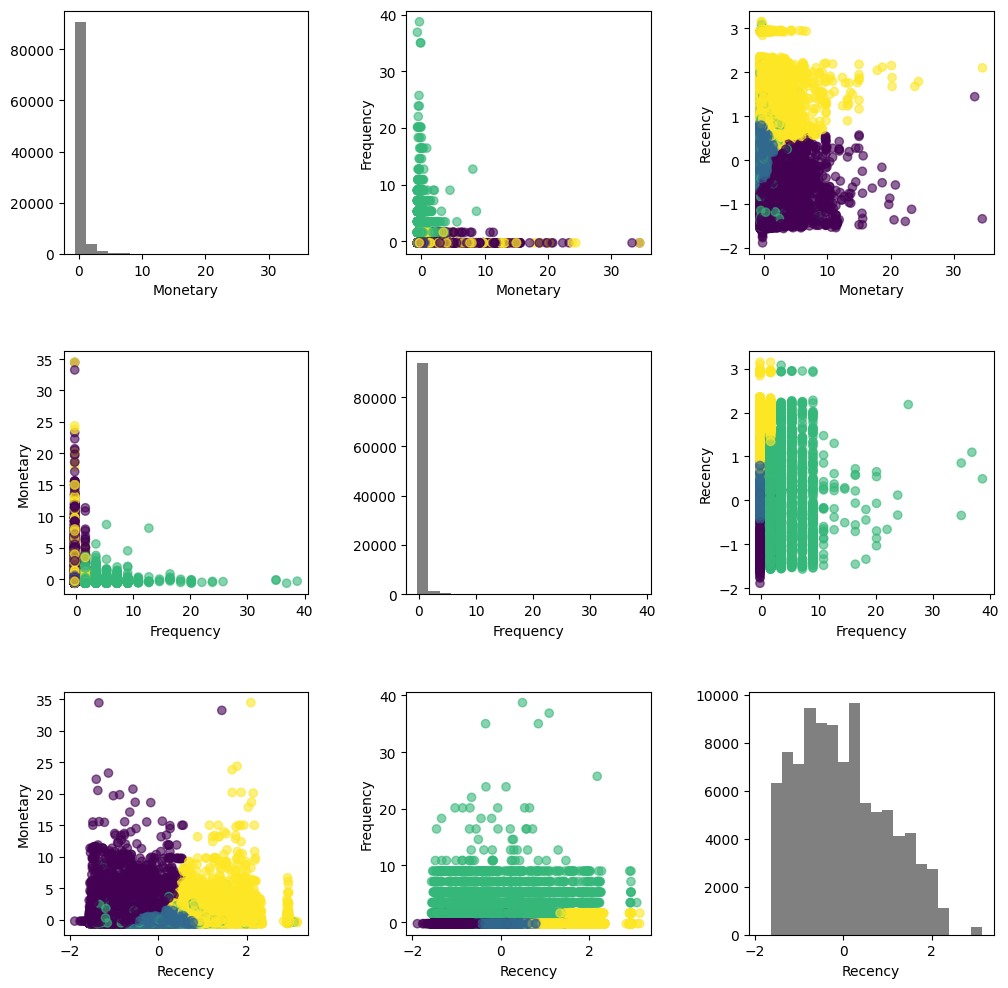

In [58]:
cluster_plots(df_rfm_scaled, variables)

La majorité des clients a une fréquence d'achat basse, et ceux qui dépensent beaucoup sont peu fréquents.

Les clusters montrent des comportements différents, notamment des clients fréquents qui dépensent peu et des clients rares qui dépensent plus.


Les clients ayant effectué des achats récemment tendent à avoir des montants monétaires variés.

On observe que certains clusters se démarquent par une récence plus élevée, correspondant à des clients inactifs.


Les clients avec une faible récence sont plus fréquents.
Il y a notamment des clients récents et fréquents formant un groupe particulier.

# RFM Extended

In [59]:
variables_extended = ['Monetary', 'Frequency', 'Recency', 'AVG_review', 'AVG_delivery_time']

df_rfm_extended_scaled = scaler.fit_transform(df_rfm_extended[variables_extended])
df_rfm_extended_scaled = pd.DataFrame(df_rfm_extended_scaled, columns=variables_extended)

## RFM Extended KMeans

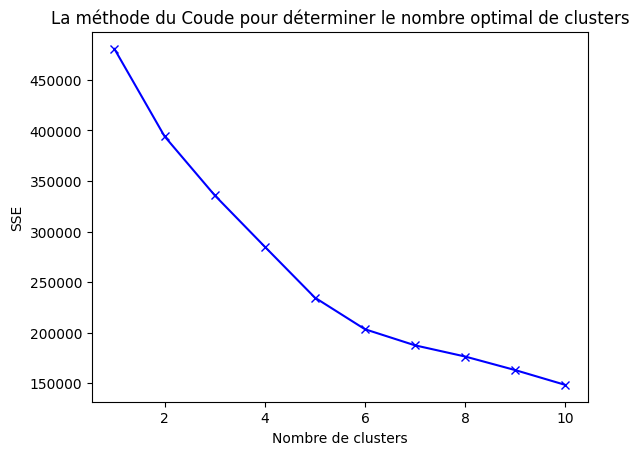

In [60]:
kmeans_plot(df_rfm_extended_scaled)


### Manually define the numbr of clusters

In [61]:
cluster_summary =store_nb_cluster(6, df_rfm_extended_scaled)

         Monetary  Frequency   Recency  AVG_review  AVG_delivery_time
Cluster                                                              
0       -0.119810  -0.143217 -0.775112    0.443587          -0.234026
1       -0.116138  -0.132553  0.992078    0.419400          -0.075107
2       -0.118145   0.057815  0.065307   -1.825657          -0.322663
3        4.944078  -0.214830  0.015910    0.071222           0.087238
4       -0.254861   5.029444 -0.016378   -0.485277          -0.089364
5        0.011913  -0.133303 -0.027332   -1.431847           2.508270


## RFM Extended Cluster Boxplot

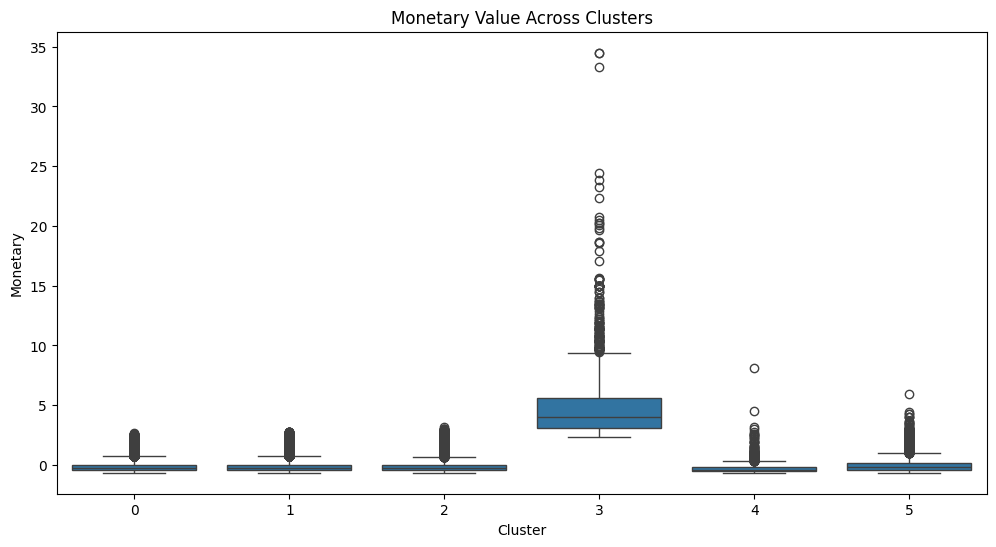

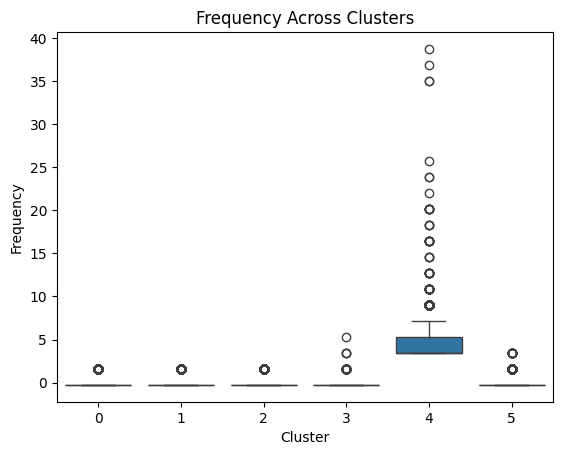

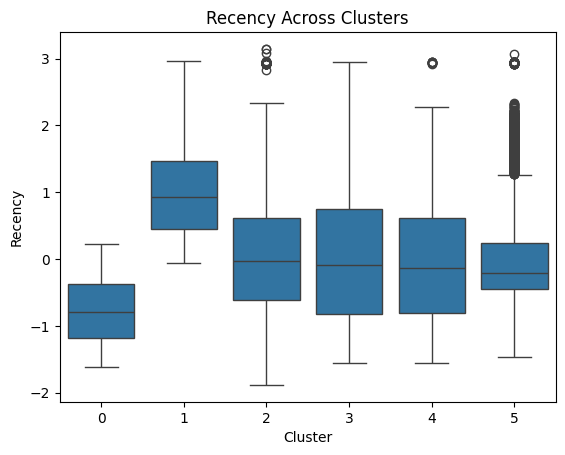

In [62]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Monetary', data=df_rfm_extended_scaled)
plt.title('Monetary Value Across Clusters')
plt.show()

sns.boxplot(x='Cluster', y='Frequency', data=df_rfm_extended_scaled)
plt.title('Frequency Across Clusters')
plt.show()

sns.boxplot(x='Cluster', y='Recency', data=df_rfm_extended_scaled)
plt.title('Recency Across Clusters')
plt.show()

## RFM Extended Radar Chart

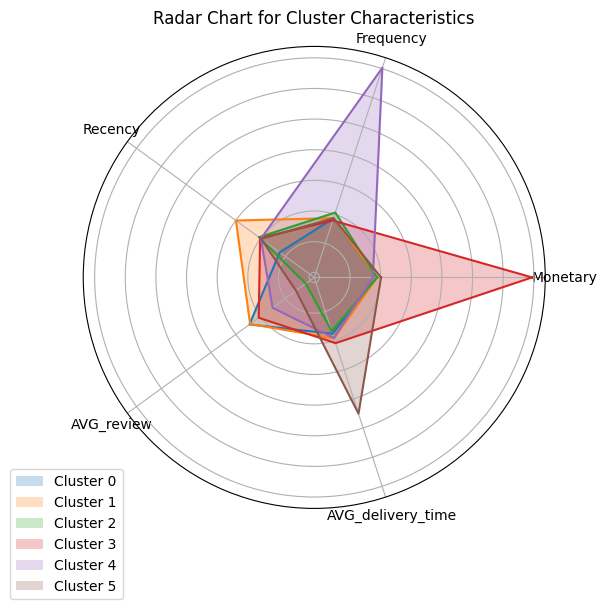

In [63]:
radar_char(cluster_summary, variables_extended)

## RFM Extended Cluster Repartition

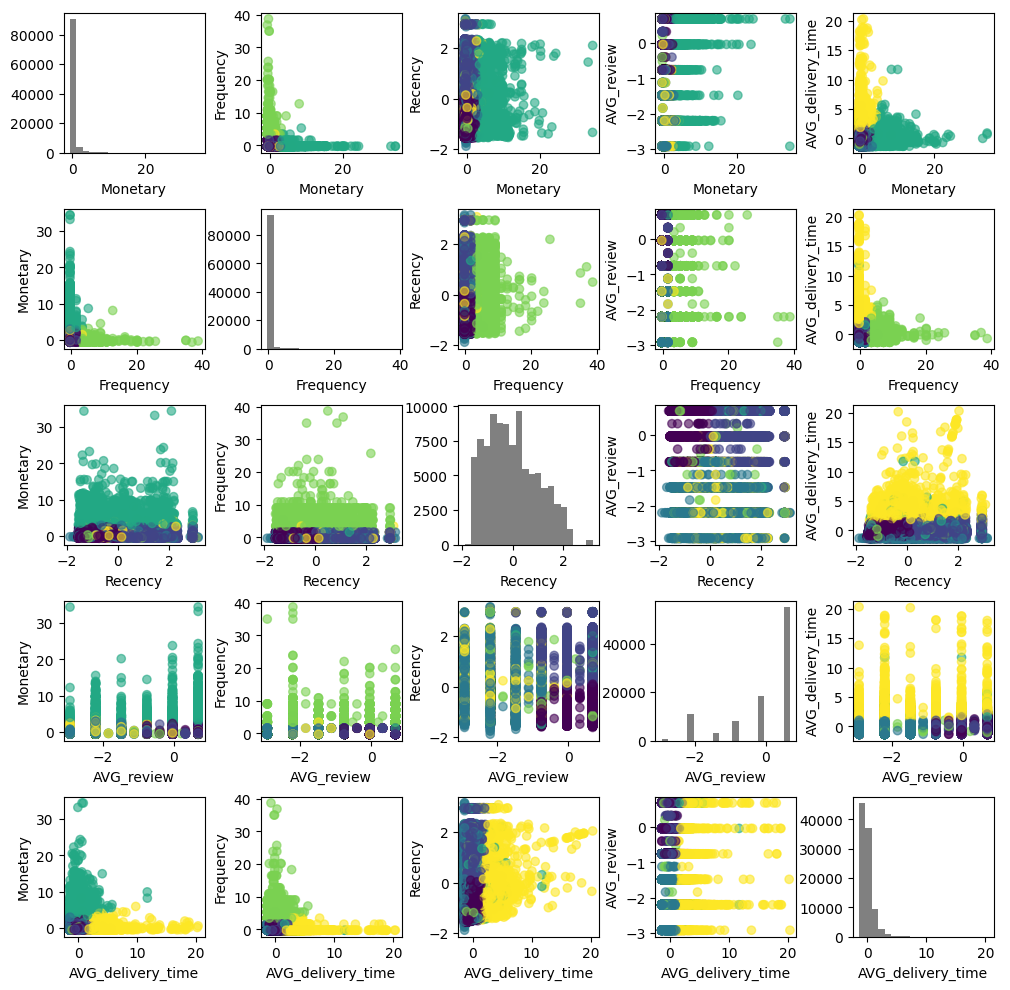

In [64]:
cluster_plots(df_rfm_extended_scaled, variables_extended)

Les clients ayant une valeur monétaire élevée  tendent à avoir des fréquences d’achat faibles, mais il existe des exceptions. Ils se distinguent également par un temps de livraison légèrement plus long.

On observe que les clients avec une haute fréquence d’achat ont tendance à avoir des temps de livraison moyens plus courts.

Il semble que les clients qui ont acheté récemment  ont une note moyenne des avis plus élevée. Les clients avec une récence élevée, qui n'ont pas acheté récemment, sont plus diversifiés dans leurs notes d'avis.

Certains groupes ayant des délais de livraison plus longs semblent donner des avis variés, tandis que d'autres groupes avec des délais plus courts tendent à mieux évaluer.

In [65]:
df_rfm_extended_scaled = df_rfm_extended_scaled.drop(columns=['Cluster' ])

# DB SCAN

## Searching for aproximative best parameters

In [66]:
def dbscanAnalysis(eps, min_samples, df) :
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
      
    labels = dbscan.fit_predict(df)

    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
    num_noise_points = list(labels).count(-1)

    if num_clusters > 1:
        silhouette_avg = silhouette_score(df, labels)
    else:
        silhouette_avg = -1  
    return {
            'eps': eps,
            'min_samples': min_samples,
            'num_clusters': num_clusters,
            'num_noise_points': num_noise_points,
            'silhouette_score': silhouette_avg
        }

In [67]:
df_sampled = df_rfm_extended_scaled.sample(n=20000, random_state=42)

eps_values = np.arange(0.1, 2.0, 0.2)

min_samples_values = np.arange(1,10,1)   

results = []

for eps in eps_values:
    for min_samples in min_samples_values: 
        results.append(dbscanAnalysis(eps, min_samples, df_sampled))


results_df = pd.DataFrame(results)

print(results_df)

    eps  min_samples  num_clusters  num_noise_points  silhouette_score
0   0.1            1          8078                 0         -0.241404
1   0.1            2          1453              6625         -0.455116
2   0.1            3           612              8307         -0.529253
3   0.1            4           335              9755         -0.556106
4   0.1            5           204             10916         -0.573640
..  ...          ...           ...               ...               ...
85  1.9            5             2                46          0.736592
86  1.9            6             1                53         -1.000000
87  1.9            7             1                54         -1.000000
88  1.9            8             1                57         -1.000000
89  1.9            9             1                59         -1.000000

[90 rows x 5 columns]


In [68]:
best_results = results_df.sort_values(by='silhouette_score', ascending=False)
print("Best results:")
print(best_results.head())

Best results:
    eps  min_samples  num_clusters  num_noise_points  silhouette_score
85  1.9            5             2                46          0.736592
83  1.9            3             4                34          0.710518
82  1.9            2             6                30          0.584877
81  1.9            1            36                 0          0.439862
44  0.9            9             7               366          0.249352


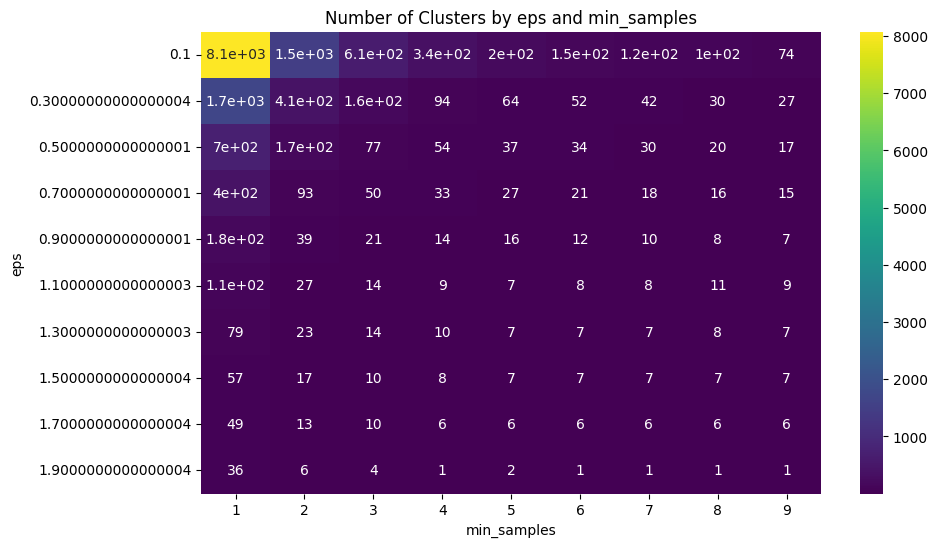

In [69]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot(index='eps', columns='min_samples', values='num_clusters'), annot=True, cmap='viridis')
plt.title('Number of Clusters by eps and min_samples')
plt.show()

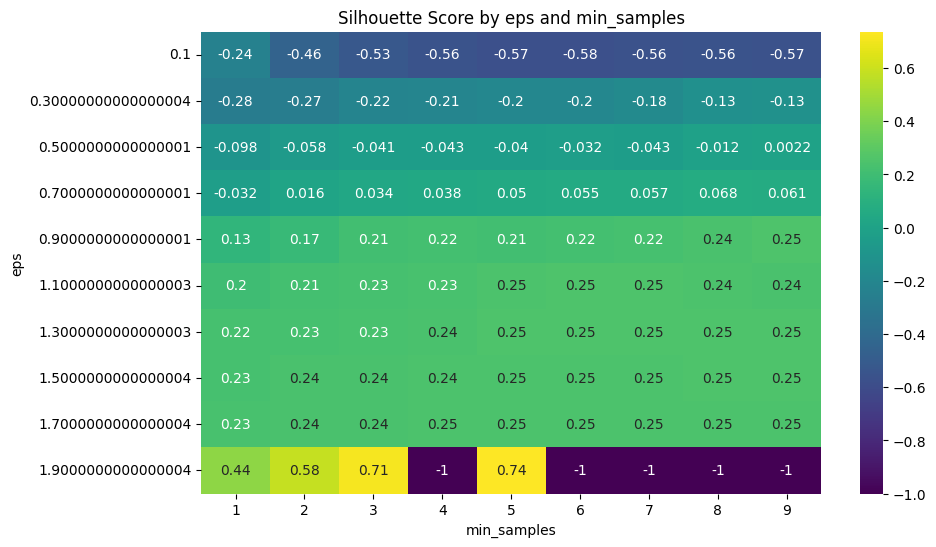

In [70]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot(index='eps', columns='min_samples', values='silhouette_score'), annot=True, cmap='viridis')
plt.title('Silhouette Score by eps and min_samples')
plt.show()

## Applying best parameters to df

In [71]:
df_sampled = df_rfm_extended.sample(n=90000, random_state=42)

df_sampled_scaled = scaler.fit_transform(df_sampled[variables_extended])
df_sampled_scaled = pd.DataFrame(df_sampled_scaled, columns=variables_extended)

In [81]:
best_eps = 1.9  
best_min_samples = 5  

dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_clusters = dbscan_model.fit_predict(df_sampled_scaled)


df_sampled['dbscan_cluster'] = dbscan_clusters

##  DB scan cluster pariplot

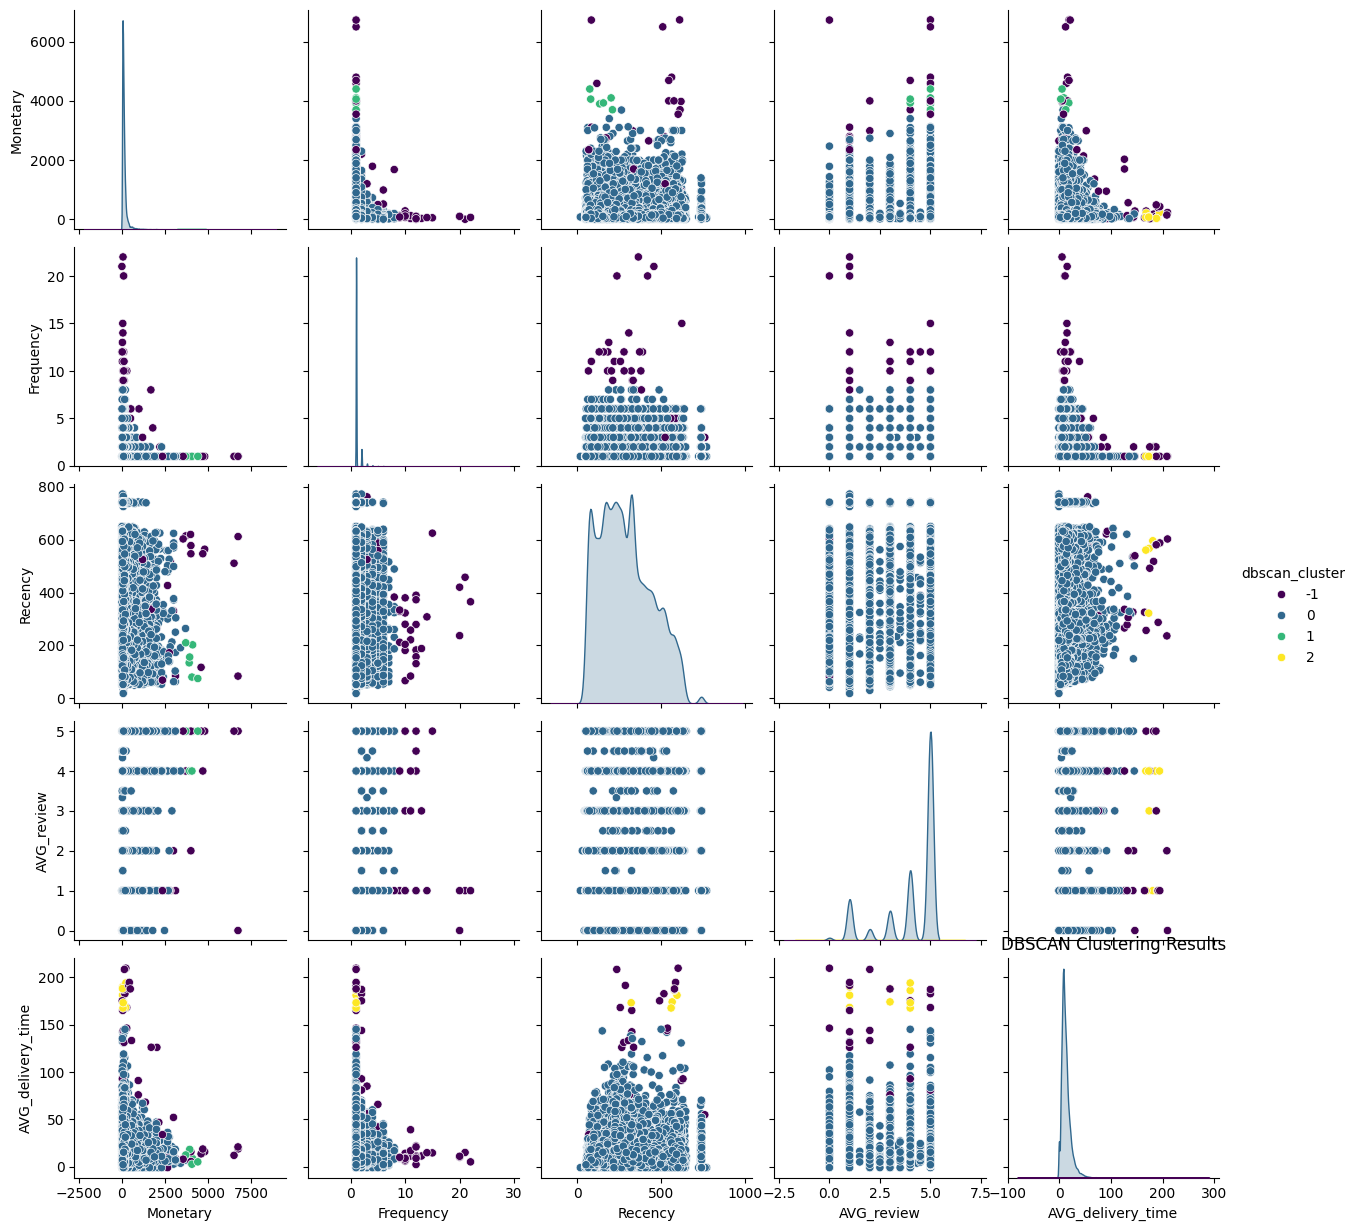

In [82]:
sns.pairplot(df_sampled, hue='dbscan_cluster', palette='viridis', diag_kind='kde')
plt.title('DBSCAN Clustering Results')
plt.show()

## DB Scan info

In [83]:
num_noise_points = sum(dbscan_clusters == -1)
print(f'Number of noise points: {num_noise_points}')

num_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)  # Exclude noise points
print(f'Number of clusters: {num_clusters}')


Number of noise points: 78
Number of clusters: 3


# Over time stability

## ARS

In [84]:
def kmeans_across_time(engine,  max_iterations=5, time_interval_days=7, n_clusters=6):
    df_rfm_extended['Last_Order_Date'] = pd.to_datetime(df_rfm_extended['Last_Order_Date'], format='%Y-%m-%d %H:%M:%S')
    latest_date = df_rfm_extended['Last_Order_Date'].max()
    
    kmeans_new = KMeans(n_clusters, random_state=42, n_init="auto")
    df_rfm_extended_scaled = StandardScaler().fit_transform(df_rfm_extended.drop(columns=['Last_Order_Date', 'customer_unique_id']))
    cluster_new = kmeans_new.fit_predict(df_rfm_extended_scaled)
    ars_data = []
    
    for i in range(max_iterations):
        cutoff_date = latest_date - pd.Timedelta(days=i * time_interval_days)

        query_old =  text(f'''
        SELECT
            customer_unique_id,
            AVG(oi.price) AS Monetary,
            COUNT(o.order_id) AS Frequency,
            JULIANDAY((SELECT MAX(order_purchase_timestamp) FROM orders)) - JULIANDAY(MAX(o.order_purchase_timestamp)) AS Recency,
            AVG(COALESCE(orv.review_score, 0)) AS AVG_review,
            AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)) AS AVG_delivery_time,
            MAX(o.order_purchase_timestamp) AS Last_Order_Date
        FROM
        orders o
        LEFT JOIN
        order_items oi ON o.order_id = oi.order_id
        LEFT JOIN
        customers c ON o.customer_id = c.customer_id
        LEFT JOIN order_reviews orv ON o.order_id = orv.order_id
        WHERE o.order_delivered_customer_date <= '{cutoff_date}'
        GROUP BY c.customer_unique_id;                 
        ''')
        
        df_old = pd.read_sql(query_old, engine).copy()
        df_old = cleandf(df_old)
        
        df_old_scaled = df_old.drop(columns=['customer_unique_id', 'Last_Order_Date'])
        scaler = StandardScaler()
        df_old_scaled = scaler.fit_transform(df_old_scaled)

        kmeans_old = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(df_old_scaled)
        cluster_old = kmeans_old.predict(df_rfm_extended_scaled)

        score = ars(cluster_old, cluster_new)
        ars_data.append({'date_gap': i * time_interval_days, 'ARS': score})

    return pd.DataFrame(ars_data)




In [85]:
def plot_ars_progress(ars_df):
    plt.figure(figsize=(8, 6))
    plt.plot(ars_df['date_gap'], ars_df['ARS'], marker='o', linestyle='-', color='b')
    plt.xlabel('Date Gap (Days)')
    plt.ylabel('Adjusted Rand Score (ARS)')
    plt.title('ARS Progress Over Time')
    plt.grid(True)
    plt.show()

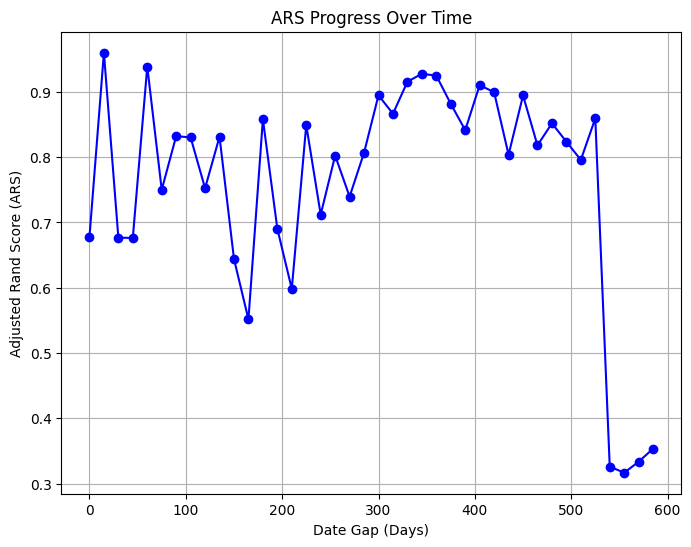

In [86]:
ars_df = kmeans_across_time(engine, 40, 15, 6)
plot_ars_progress(ars_df)

## Kolmogorov Smirnov across time

In [87]:


def kolmogorov_smirnov_across_time(engine, max_iterations=5, time_interval_days=7):
    latest_date_query = '''SELECT MAX(order_purchase_timestamp) AS latest_date FROM orders'''
    latest_date = pd.read_sql(latest_date_query, engine)['latest_date'].max()
    latest_date = pd.to_datetime(latest_date, format='%Y-%m-%d %H:%M:%S')

    ks_data = []

    for i in range(max_iterations):
        cutoff_date = latest_date - pd.Timedelta(days=i * time_interval_days)
        print(f"Cutoff date: {cutoff_date}")

        query = f'''
        SELECT
            customer_unique_id,
            AVG(oi.price) AS Monetary,
            COUNT(o.order_id) AS Frequency,
            JULIANDAY('{cutoff_date}') - JULIANDAY(MAX(o.order_purchase_timestamp)) AS Recency,
            AVG(COALESCE(orv.review_score, 0)) AS AVG_review,
            AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)) AS AVG_delivery_time,
            MAX(o.order_purchase_timestamp) AS Last_Order_Date
        FROM orders o
        LEFT JOIN order_items oi ON o.order_id = oi.order_id
        LEFT JOIN customers c ON o.customer_id = c.customer_id
        LEFT JOIN order_reviews orv ON o.order_id = orv.order_id
        WHERE o.order_delivered_customer_date <= '{cutoff_date}'
        GROUP BY c.customer_unique_id
        '''

        df_old = pd.read_sql(query, engine).copy()

        df_old_cleaned = cleandf(df_old)

        if i > 0:
            for col in ['Monetary', 'Frequency', 'Recency', 'AVG_review', 'AVG_delivery_time']:
                ks_stat, ks_p_value = ks_2samp(prev_df[col], df_old_cleaned[col])
                ks_data.append({
                    'date_gap': i * time_interval_days,
                    'feature': col,
                    'ks_stat': ks_stat,
                    'ks_p_value': ks_p_value
                })

        prev_df = df_old_cleaned

    return pd.DataFrame(ks_data)




In [88]:
ks_df = kolmogorov_smirnov_across_time(engine, 40, 15)
print(ks_df)

Cutoff date: 2018-10-17 17:30:18
Cutoff date: 2018-10-02 17:30:18
Cutoff date: 2018-09-17 17:30:18
Cutoff date: 2018-09-02 17:30:18
Cutoff date: 2018-08-18 17:30:18
Cutoff date: 2018-08-03 17:30:18
Cutoff date: 2018-07-19 17:30:18
Cutoff date: 2018-07-04 17:30:18
Cutoff date: 2018-06-19 17:30:18
Cutoff date: 2018-06-04 17:30:18
Cutoff date: 2018-05-20 17:30:18
Cutoff date: 2018-05-05 17:30:18
Cutoff date: 2018-04-20 17:30:18
Cutoff date: 2018-04-05 17:30:18
Cutoff date: 2018-03-21 17:30:18
Cutoff date: 2018-03-06 17:30:18
Cutoff date: 2018-02-19 17:30:18
Cutoff date: 2018-02-04 17:30:18
Cutoff date: 2018-01-20 17:30:18
Cutoff date: 2018-01-05 17:30:18
Cutoff date: 2017-12-21 17:30:18
Cutoff date: 2017-12-06 17:30:18
Cutoff date: 2017-11-21 17:30:18
Cutoff date: 2017-11-06 17:30:18
Cutoff date: 2017-10-22 17:30:18
Cutoff date: 2017-10-07 17:30:18
Cutoff date: 2017-09-22 17:30:18
Cutoff date: 2017-09-07 17:30:18
Cutoff date: 2017-08-23 17:30:18
Cutoff date: 2017-08-08 17:30:18
Cutoff dat

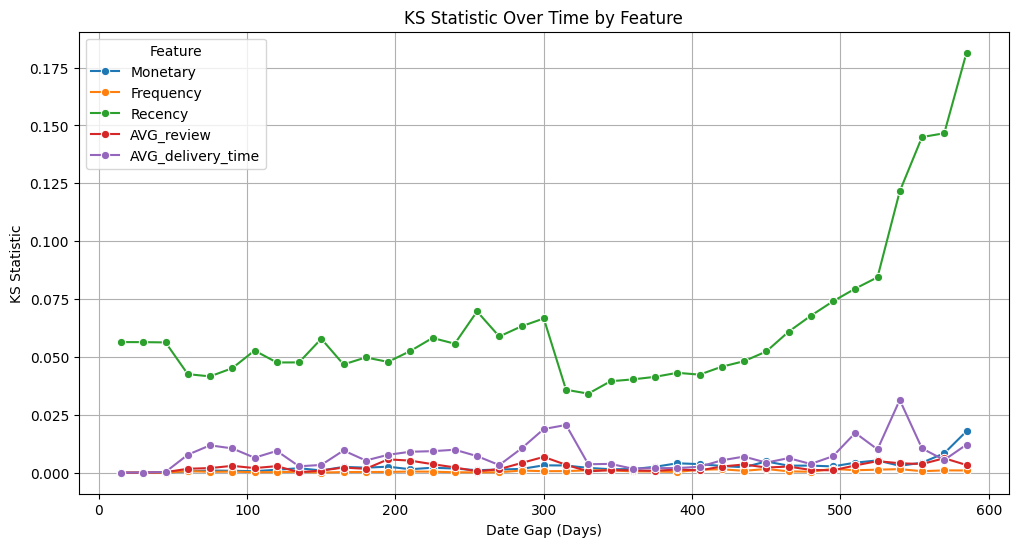

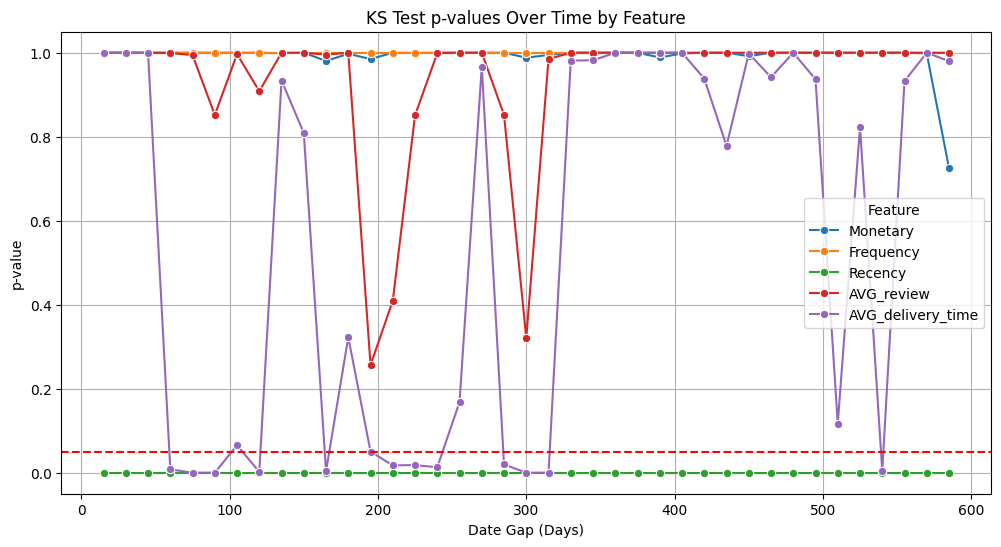

In [89]:
def plot_ks_results(ks_df):
    """
    Function to plot KS test results over time for different features.
    :param ks_df: DataFrame containing the KS results with 'date_gap', 'feature', 'ks_stat', and 'ks_p_value'.
    """

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=ks_df, x='date_gap', y='ks_stat', hue='feature', marker='o')
    plt.title('KS Statistic Over Time by Feature')
    plt.xlabel('Date Gap (Days)')
    plt.ylabel('KS Statistic')
    plt.grid(True)
    plt.legend(title='Feature')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=ks_df, x='date_gap', y='ks_p_value', hue='feature', marker='o')
    plt.title('KS Test p-values Over Time by Feature')
    plt.xlabel('Date Gap (Days)')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.legend(title='Feature')
    plt.axhline(y=0.05, color='r', linestyle='--', label='p = 0.05')
    plt.show()


plot_ks_results(ks_df)
